# Instacart Consumer Purchase Exploratory Data Analysis

**Background**

Instacart is a grocery ordering and delivery app that aims to make it easy to fill your refrigerator and pantry with your personal favorites and staples when you need them. After selecting products through the Instacart app, personal shoppers review your order and do the in-store shopping and delivery for you.

Instacart has:
- 100s of retailers
- 10,000s of stores
- 10,000s of shoppers
- 1,00,000s of products
- 100,000,000s of items

Instacart's data science team uses transactional data to develop models that predict which products a user will buy again, try for the first time, or add to their cart next during a session.

(https://tech.instacart.com/predicting-real-time-availability-of-200-million-grocery-items-in-us-canada-stores-61f43a16eafe)

(https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2)

**Data**

The dataset is a relational set of files describing customers' orders over time. The goal is to predict which products will be in a user's next order. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200K Instacart users. For each user, we provide between 4 and 100 of their orders, with the sequence of products purchased in each order. We also provide the week and hour of day the order was placed, and a relative measure of time between orders.

(https://www.kaggle.com/c/instacart-market-basket-analysis)

**Possible problem**

Because Instacart does not have the logistics supply chain information for products, when an item that a customer adds to the cart is unavailable in store, it costs every stakeholder in Instacart's marketplace. Shoppers waste time searching for an unavailable item, customers can't buy what they want, and retail partners lose out on revenue.

By proactively and accurately predicting customers' buying behavior, Instacart can use this information to match and search through their availability prediction model of whether a certain item out of the 200 million grocery items is available in real-time and make appropriate recommendations to the customer for the out-of-stock item(s) if applicable.

**Possible prediction tasks**
- Products that a user will buy again
- Products that a user will try for the first time
- Products that a user will add to cart next during a session
- Products that a user will buy together
- Time that a user will make the next purchase

In [1]:
import pandas as pd
import numpy as np
import scipy as sc

import dask.array as da
import dask.dataframe as dd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Load data

- `orders` (3.4m rows, 206k users):
    - `order_id`: order identifier
    - `user_id`: customer identifier
    - `eval_set`: which evaluation set this order belongs in (see SET described below)
    - `order_number`: the order sequence number for this user (1 = first, n = nth)
    - `order_dow`: the day of the week the order was placed on
    - `order_hour_of_day`: the hour of the day the order was placed on
    - `days_since_prior_order`: days since the last order, capped at 30 (with NAs for order_number = 1)
    
    
- `products` (50k rows):
    - `product_id`: product identifier
    - `product_name`: name of the product
    - `aisle_id`: foreign key
    - `department_id`: foreign key


- `aisles` (134 rows):
    - `aisle_id`: aisle identifier
    - `aisle`: the name of the aisle
    
    
- `departments` (21 rows):
    - `department_id`: department identifier
    - `department`: the name of the department
    
    
- `order_products__SET` (30m+ rows):
    - `order_id`: foreign key
    - `product_id`: foreign key
    - `add_to_cart_order`: order in which each product was added to cart
    - `reordered`: 1 if this product has been ordered by this user in the past, 0 otherwise
    
   
    where SET is one of the three following evaluation sets (eval_set in orders):
         - "prior": orders prior to that users most recent order (~3.2m orders)
         - "train": training data supplied to participants (~131k orders)
         - "test": test data reserved for machine learning competitions (~75k orders)

In [2]:
# read in the data from a list of csv file names
filenames = ['aisles', 'departments', 'order_products__prior', 'order_products__train', 'orders', 'products', 'sample_submission']

dfs = []
csv_files = [f +'.csv' for f in filenames]
for csv in csv_files:
    dfs.append(pd.read_csv(csv, encoding="utf-8"))

In [3]:
# create a separate variable for each of the dataframes read in from the csv 
for x, y in zip(filenames, dfs):
    globals()[x] = y

# Clean the Data

Let's look at the column names to decide how to merge the six different data frames.

In [4]:
aisles_col = aisles.columns.tolist()
depart_col = departments.columns.tolist()
prod_col = products.columns.tolist()
order_prod_prior_col = order_products__prior.columns.tolist()
order_prod_train_col = order_products__train.columns.tolist()
orders_col = orders.columns.tolist()

print('aisles')
print(aisles_col)
print('\ndepartments')
print(depart_col)
print('\nproducts')
print(prod_col)
print('\norder products prior')
print(order_prod_prior_col)
print('\norder_products_train')
print(order_prod_train_col)
print('\norders')
print(orders_col)

aisles
[u'aisle_id', u'aisle']

departments
[u'department_id', u'department']

products
[u'product_id', u'product_name', u'aisle_id', u'department_id']

order products prior
[u'order_id', u'product_id', u'add_to_cart_order', u'reordered']

order_products_train
[u'order_id', u'product_id', u'add_to_cart_order', u'reordered']

orders
[u'order_id', u'user_id', u'eval_set', u'order_number', u'order_dow', u'order_hour_of_day', u'days_since_prior_order']


## Combining the Data

### Goods Data Frame of the Products and Their Information

In [5]:
goods = products.merge(aisles, on='aisle_id', how='left').merge(departments, on='department_id', how='left')
goods.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


In [6]:
print('There are {} unique products, {} aisles, and {} departments.'.format(goods['product_id'].nunique(),
                                                                            goods['aisle'].nunique(),
                                                                            goods['department'].nunique()))

There are 49688 unique products, 134 aisles, and 21 departments.


### Orders Data Frame

In [7]:
print('There are {} unique users and {} orders.'.format(orders['user_id'].nunique(), orders['order_id'].nunique()))

There are 206209 unique users and 3421083 orders.


In [8]:
orders_products_prior = order_products__prior.merge(goods, on='product_id', how='left')
orders_products_prior = orders_products_prior.drop(['product_id', 'aisle_id', 'department_id'], axis=1)

In [9]:
orders_products_train = order_products__train.merge(goods, on='product_id', how='left')
orders_products_train = orders_products_train.drop(['product_id', 'aisle_id', 'department_id'], axis=1)

In [10]:
dow_order = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
dow = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
orders['order_dow'] = orders['order_dow'].map(dow_order).astype('category', categories=dow, ordered=True)

### Data Frame for Market Basket Analysis (MBA)

In [11]:
df = pd.concat([orders_products_prior, orders_products_train])
print(len(df))
mba = orders.merge(df, on='order_id', how='right')
print(len(mba))

33819106
33819106


**The test set in `orders` is omitted after merging with the order and product information because the original task from the Kaggle competition was to predict which products customers would reorder so the respective order and product information is missing.**

## Understanding the Data

In [12]:
mba.dtypes

order_id                     int64
user_id                      int64
eval_set                    object
order_number                 int64
order_dow                 category
order_hour_of_day            int64
days_since_prior_order     float64
add_to_cart_order            int64
reordered                    int64
product_name                object
aisle                       object
department                  object
dtype: object

### Null Values

In [13]:
mba.isnull().sum()

order_id                        0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
add_to_cart_order               0
reordered                       0
product_name                    0
aisle                           0
department                      0
dtype: int64

In [14]:
first_time = mba[(mba['order_number']==1) & (mba['days_since_prior_order'].isnull())]
len(mba[(mba['order_number']==1)]) == len(mba[mba['days_since_prior_order'].isnull()]) == 2078068

True

**The *mba* datasets are very clean with only NA values in the `days_since_prior_order` column. This column contains NA values because those respective customers are shopping at Instacart for the first time (`order_number` = 1). Customers with a `days_since_prior_order` value of 0 have made a purchase earlier that same day.**

### Outliers

In [15]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# Descriptive statistics for the non-nominal numerical features of the orders dataset
mba.describe().drop(['user_id', 'order_id'], axis=1)

,order_number,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered
count,33819106.00,33819106.00,31741038.00,33819106.00,33819106.00
mean,17.14,13.43,11.36,8.37,0.59
std,17.50,4.25,8.94,7.14,0.49
min,1.00,0.00,0.00,1.00,0.00
25%,5.00,10.00,5.00,3.00,0.00
50%,11.00,13.00,8.00,6.00,1.00
75%,24.00,16.00,15.00,11.00,1.00
max,100.00,23.00,30.00,145.00,1.00


**`order_number`:**
- **The least number of orders a customer placed is 1**
- **The average customer placed 17 orders**
- **Half the customers placed less than 11 orders or less while the other half placed 11 orders or more**
- **the most number of orders placed by a customer is 100**
- **The distribution is slightly right skewed (mean > median)**

**`order_hour_of_day`:**
- **On average, orders were placed between 1-2 PM (13.43)**
- **Half the orders were placed on or before 1 PM, while the other half on or after 1 PM**

**`days_since_prior_order`**:
- **Because this feature is capped at 30 days, the maximum is 30**
- **Because customers can place more than one order a day, the minimum is 0**
- **On average, the previous order was placed roughly 11 days ago**
- **Half the orders were placed 8 or less days ago, while the other half were placed 8 or more days ago**

**`add_to_cart_order`**:
- **The average number of items in a cart is about 8**
- **The minimum cart size is 1**
- **The maximum cart size is 145**
- **The median cart size is 6, which means that the data for this column is right skewed because the median is less than the mean**

**`reordered`:**
- **59% of the time products were reordered**

**Let's see how many users have placed 100 orders on Instacart.**

In [16]:
max_order_users = mba.loc[mba['order_number'] == 100].groupby('user_id')['order_id'].nunique().reset_index(name='count')
print('There are {} users who have made 100 orders on Instacart.'.format(len(max_order_users)))

There are 867 users who have made 100 orders on Instacart.


# Exploratory Data Analysis

In [17]:
mba.columns.tolist()

[u'order_id',
 u'user_id',
 u'eval_set',
 u'order_number',
 u'order_dow',
 u'order_hour_of_day',
 u'days_since_prior_order',
 u'add_to_cart_order',
 u'reordered',
 u'product_name',
 u'aisle',
 u'department']

### How Many Orders Do Customers Place?

In [18]:
num_orders_user = mba.groupby('user_id')['order_number'].max().reset_index(name='num_of_orders')
num_orders_user.head()

,user_id,num_of_orders
0,1,11
1,2,15
2,3,12
3,4,5
4,5,5


Text(0,0.5,'Frequency')

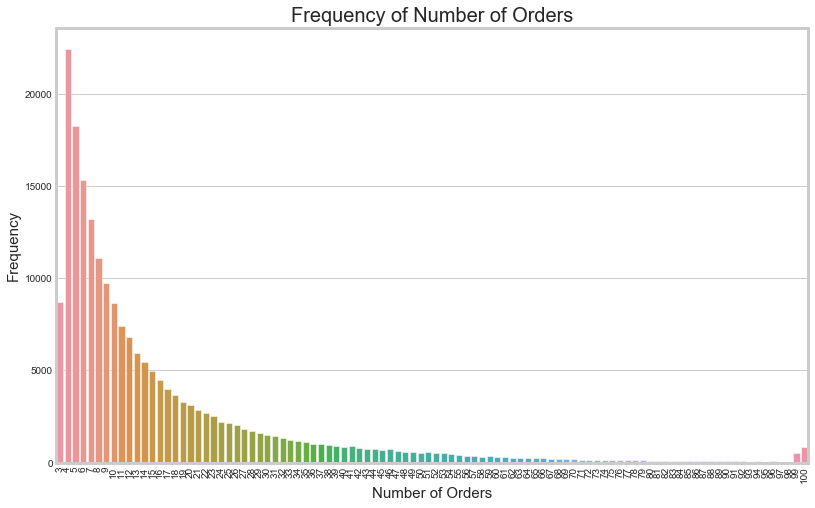

In [19]:
freq = num_orders_user.num_of_orders.value_counts()

sns.set_style('whitegrid')
plt.subplots(figsize=(12, 8))
plt.xticks(rotation='vertical')

sns.barplot(freq.index, freq.values)
plt.title('Frequency of Number of Orders', fontsize=20)
plt.xlabel('Number of Orders', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

**Most customers placed around 4-7 Instacart orders. There seems to be a bump at 100 orders because the dataset is capped at 4-100 orders; hence, 100+ orders are lumped into the 100 orders category. The orginal orders dataset contains users with 4-100 orders. However, there are some users with 3 orders because one of their orders were in the test set that was omitted when combining the datasets to create the MBA dataset.**

Text(0.5,0,'Number of Orders')

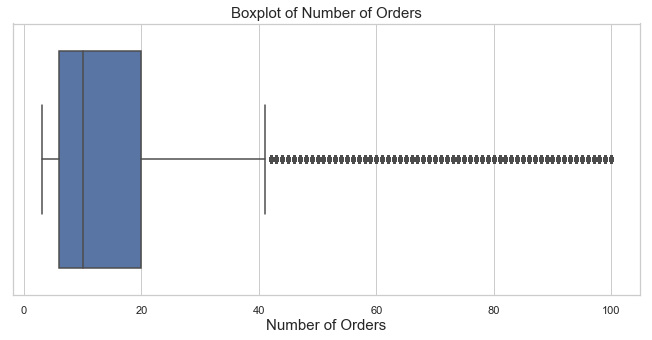

In [20]:
sns.set(style='whitegrid')
f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x=num_orders_user['num_of_orders'])

plt.title('Boxplot of Number of Orders', fontsize=15)
plt.xlabel('Number of Orders', fontsize=15)

**A majority of the customers had approximately 3 to 40 orders. The median seems to be located at 10 orders, and the spread (Q3 - Q1 = ~15) of the middle 50% of the data is fairly small.**

### How Many Orders Do Customers Place by Day of Week?

In [21]:
orders_dow = mba.groupby('order_dow')['order_id'].nunique().reset_index(name='count')
orders_dow.head()

,order_dow,count
0,Sunday,585237
1,Monday,576377
2,Tuesday,458074
3,Wednesday,428087
4,Thursday,417171


Text(0,0.5,'Number of Orders')

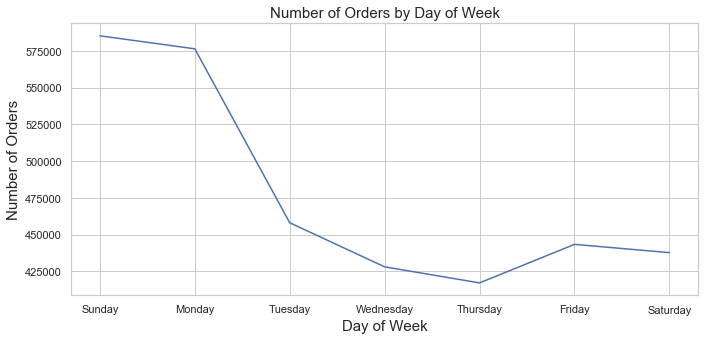

In [22]:
sns.set(style='whitegrid')
f, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=orders_dow['order_dow'], y=orders_dow['count'])

plt.title('Number of Orders by Day of Week', fontsize=15)
plt.xlabel('Day of Week', fontsize=15)
plt.ylabel('Number of Orders', fontsize=15)

**There are more orders placed early on in the week (Sunday, and Monday). This may be because users shop for groceries for the rest of the week. The number of orders decreases into the middle of the week and increases again as the weekend approaches, which may be because working families have more time to cook on the weekends.**

In [23]:
orders_dow = mba.groupby(['order_dow', 'order_hour_of_day'])['order_id'].nunique().reset_index(name='count')
orders_dow.head()

,order_dow,order_hour_of_day,count
0,Sunday,0,3841
1,Sunday,1,2336
2,Sunday,2,1376
3,Sunday,3,933
4,Sunday,4,782


Text(0,0.5,'Number of Orders')

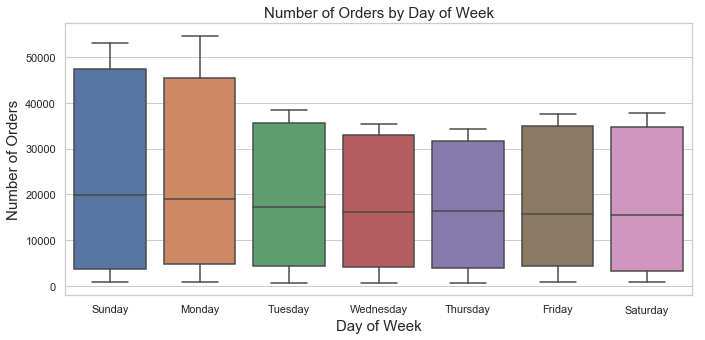

In [24]:
sns.set(style='whitegrid')
f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x=orders_dow['order_dow'], y=orders_dow['count'])

plt.title('Number of Orders by Day of Week', fontsize=15)
plt.xlabel('Day of Week', fontsize=15)
plt.ylabel('Number of Orders', fontsize=15)

**There is more spread for Sunday and Monday, and the median number of orders fluctuates between 1500000 to 200000 across the different days of the week.**

### How Many Orders Do Customers Place by Hour of Day?

In [25]:
orders_hod = mba.groupby('order_hour_of_day')['order_id'].nunique().reset_index(name='count')
orders_hod.head()

,order_hour_of_day,count
0,0,22224
1,1,12103
2,2,7375
3,3,5343
4,4,5393


Text(0,0.5,'Number of Orders')

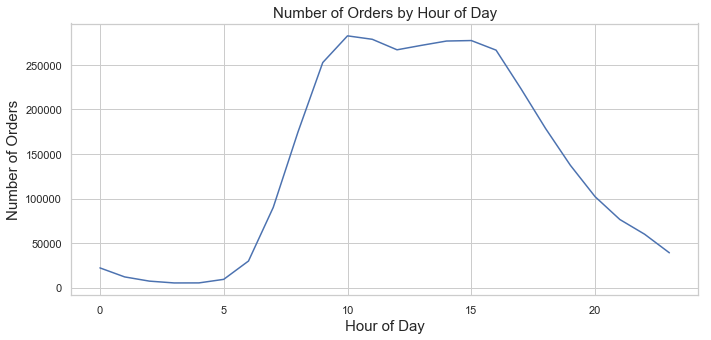

In [26]:
sns.set(style='whitegrid')
f, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=orders_hod['order_hour_of_day'], y=orders_hod['count'])

plt.title('Number of Orders by Hour of Day', fontsize=15)
plt.xlabel('Hour of Day', fontsize=15)
plt.ylabel('Number of Orders', fontsize=15)

**The number of orders are the highest at 10 AM and 3 PM. Users tend to order around noon as indicated by the rounded top of the peak. This might be because users are purchasing already made salads for lunchtime and groceries before dinner time. Hence, we observe that users don't usually order during or after dinner hours. The number of orders start plummeting after 4 PM. We observe few orders before midnight and between midnight and 6AM because not a lot of stores open until midnight and most stores don't open until 6 AM.**

In [27]:
orders_hod = mba.groupby(['order_hour_of_day', 'order_dow'])['order_id'].nunique().reset_index(name='count')
orders_hod.head()

,order_hour_of_day,order_dow,count
0,0,Sunday,3841
1,0,Monday,3594
2,0,Tuesday,3007
3,0,Wednesday,2870
4,0,Thursday,2571


Text(0,0.5,'Number of Orders')

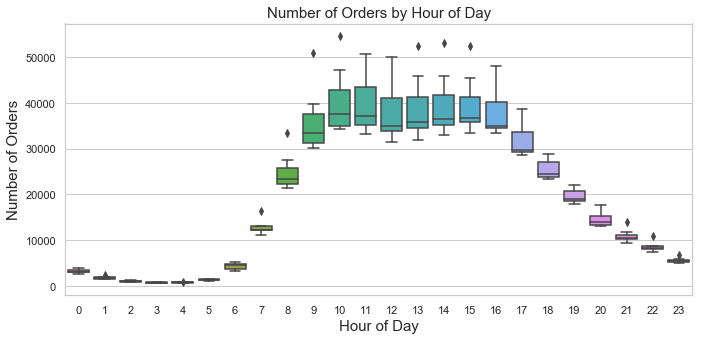

In [28]:
sns.set(style='whitegrid')
f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x=orders_hod['order_hour_of_day'], y=orders_hod['count'])

plt.title('Number of Orders by Hour of Day', fontsize=15)
plt.xlabel('Hour of Day', fontsize=15)
plt.ylabel('Number of Orders', fontsize=15)

**The median number of orders increases throughout the day until 4 PM, peaking around the late morning (10 AM - 11 PM) to early afternoon hours (12 PM - 3 PM). The spread also increases with the median because there are more orders rolling in and therefore more variability in the data than late in the evening or during the wee hours.**

### How Many Orders Do Customers Place by Day of Week vs. Hour of Day?

In [29]:
dow_vs_hod = mba.groupby(['order_dow', 'order_hour_of_day'])['order_id'].nunique().reset_index(name='count')
dow_vs_hod = dow_vs_hod.pivot('order_dow', 'order_hour_of_day', 'count')
dow_vs_hod.head()

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
order_dow,,,,,,,,,,,,,,,,,,,,,,,,
Sunday,3841,2336,1376,933,782,1142,3254,12097,27445,39764,47244,49711,50144,52414,53077,52538,48173,38674,28755,22014,17795,14075,10945,6708
Monday,3594,1791,1091,728,791,1581,5282,16294,33561,51027,54719,50640,46153,45832,45853,45504,43868,36005,28381,21699,15979,11716,8781,5507
Tuesday,3007,1543,928,709,731,1377,4670,13012,24227,35635,38486,37437,35018,35957,36387,36711,36762,31438,25899,19680,14780,10458,7971,5251
Wednesday,2870,1460,932,635,691,1322,4467,12157,22124,31694,35316,34543,32789,33439,34060,35208,34538,29786,24454,18862,13544,10077,8041,5078
Thursday,2571,1477,870,669,718,1306,4313,12274,21392,30779,34305,33132,31519,32021,32930,33435,33363,28722,23854,18921,13883,10583,8621,5513


Text(34.0531,0.5,'Day of Week')

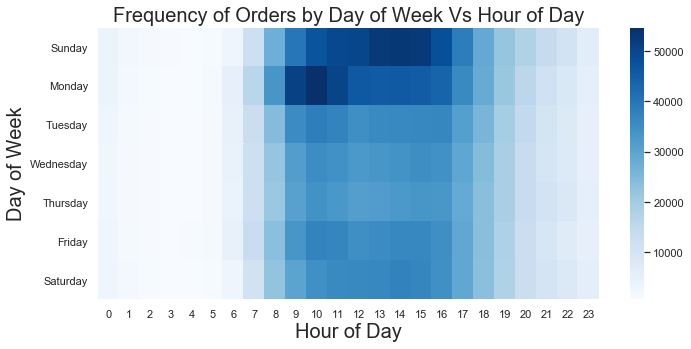

In [30]:
sns.set(style='whitegrid')
plt.figure(figsize=(10, 5))
sns.heatmap(dow_vs_hod, cmap='Blues')

plt.title('Frequency of Orders by Day of Week Vs Hour of Day', fontsize=20)
plt.xlabel('Hour of Day', fontsize=20)
plt.ylabel('Day of Week', fontsize=20)

**Most orders are placed between 10 AM - 4 PM on Sundays and 9 AM - 3 PM on Mondays. Customers also tend to place orders between 11 AM - 3 PM on Saturdays but at a lower frequency.**

### How Many Items are in the Orders?

In [31]:
num_items_order = mba.groupby('order_id')['add_to_cart_order'].max().reset_index(name='num_of_items')
num_items_order.head()

,order_id,num_of_items
0,1,8
1,2,9
2,3,8
3,4,13
4,5,26


Text(0,0.5,'Frequency')

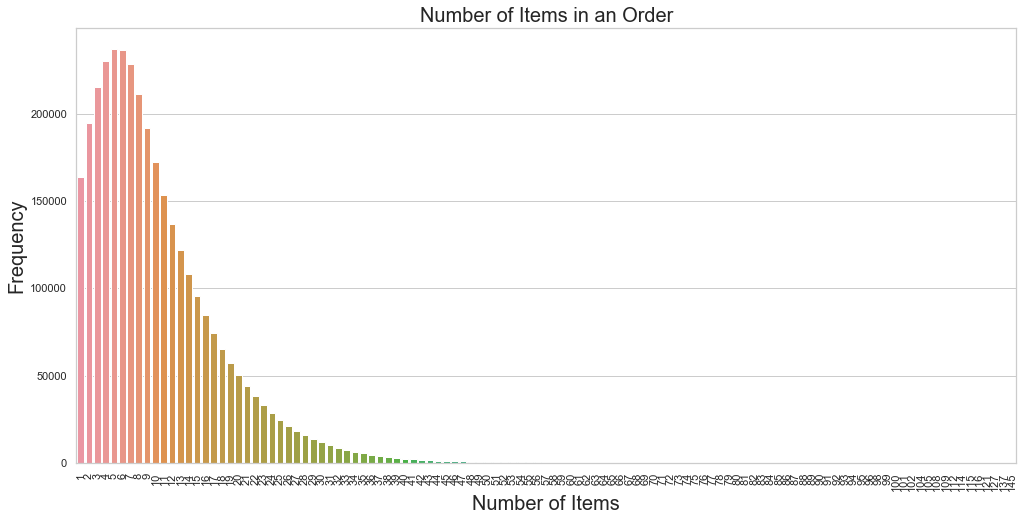

In [32]:
freq = num_items_order.num_of_items.value_counts()

sns.set_style('whitegrid')
plt.subplots(figsize=(15, 8))
plt.xticks(rotation='vertical')

sns.barplot(freq.index, freq.values)
plt.title('Number of Items in an Order', fontsize=20)
plt.xlabel('Number of Items', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

**Most people, on average, have around 3-8 items in each order.**

(0, 150)

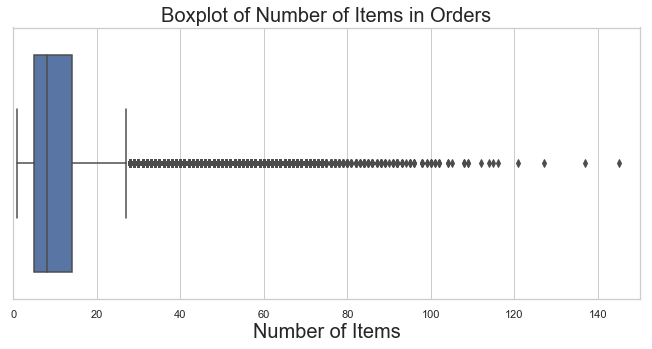

In [33]:
sns.set_style('whitegrid')
plt.subplots(figsize=(10, 5))

sns.boxplot(x=num_items_order['num_of_items'])
plt.title('Boxplot of Number of Items in Orders', fontsize=20)
plt.xlabel('Number of Items', fontsize=20)
plt.xlim(0, 150)

**The spread (Q3 - Q1) of the middle 50% of the data is roughly 10. The data is right skewed with a maximum of 145 items in a single order. Most of the orders contain 1-30 products although there are quite a number of orders with more than 30 items displayed as outliers (individual points plotted beyond the upper whisker of the boxplot).**

### How Many Items Do Customers Order by Day of Week?

In [34]:
items_dow = mba.groupby('order_dow')['product_name'].count().reset_index(name='count')
items_dow.head()

,order_dow,count
0,Sunday,6533692
1,Monday,5871834
2,Tuesday,4378360
3,Wednesday,3998498
4,Thursday,3942696


Text(0,0.5,'Number of Items')

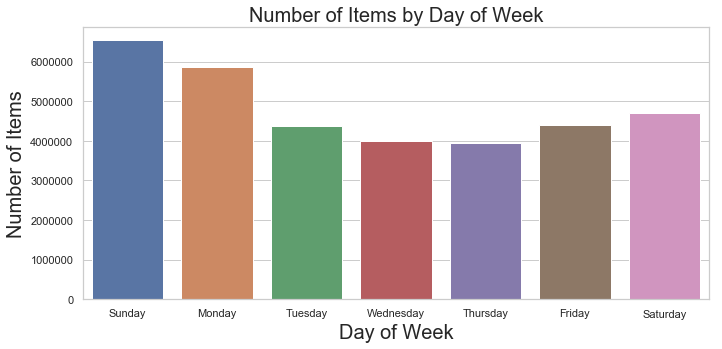

In [35]:
sns.set_style('whitegrid')
plt.subplots(figsize=(10, 5))

sns.barplot(items_dow['order_dow'], items_dow['count'])
plt.title('Number of Items by Day of Week', fontsize=20)
plt.xlabel('Day of Week', fontsize=20)
plt.ylabel('Number of Items', fontsize=20)

**This is consistent with what we have been seeing: there are more orders placed during Monday and the weekends. Hence, there should be more items purchased on these two days of the week.**

In [36]:
items_dow = mba.groupby(['order_dow', 'order_hour_of_day'])['product_name'].count().reset_index(name='count')
items_dow.head()

,order_dow,order_hour_of_day,count
0,Sunday,0,40444
1,Sunday,1,23647
2,Sunday,2,13566
3,Sunday,3,9375
4,Sunday,4,8739


Text(0,0.5,'Number of Items')

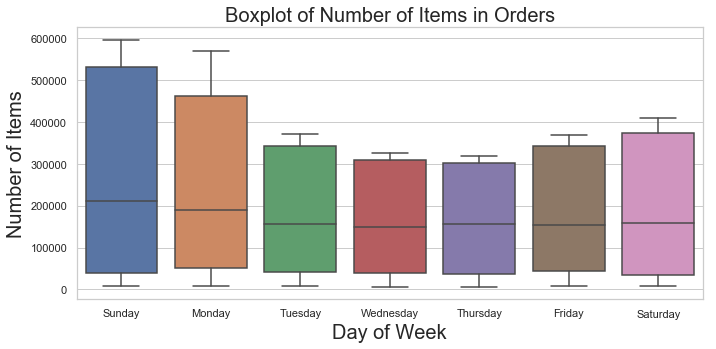

In [37]:
sns.set(style='whitegrid')
plt.subplots(figsize=(10, 5))

sns.boxplot(items_dow['order_dow'], items_dow['count'])
plt.title('Boxplot of Number of Items in Orders', fontsize=20)
plt.xlabel('Day of Week', fontsize=20)
plt.ylabel('Number of Items', fontsize=20)

**Again, there's more spread for Sunday and Monday and the trend for the median numbers of items purchased across the days of the week mirror the heights of the above barplots.**

### How Many Items Do Customers Order by Hour of Day?

In [38]:
items_hod = mba.groupby('order_hour_of_day')['product_name'].count().reset_index(name='count')
items_hod.head()

,order_hour_of_day,count
0,0,228031
1,1,121412
2,2,72660
3,3,53759
4,4,55714


Text(0,0.5,'Number of Items')

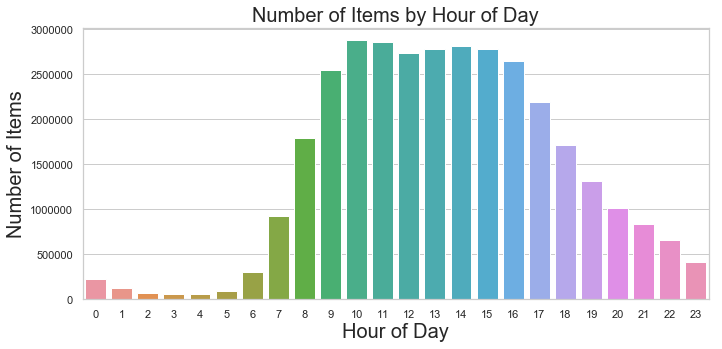

In [39]:
sns.set(style='whitegrid')
plt.subplots(figsize=(10, 5))

sns.barplot(items_hod['order_hour_of_day'], items_hod['count'])
plt.title('Number of Items by Hour of Day', fontsize=20)
plt.xlabel('Hour of Day', fontsize=20)
plt.ylabel('Number of Items', fontsize=20)

**The trend of the number of items purchased by hour of day is similar to that of the number of orders placed by hour of day. This is consistent with our intuition that the number of items purchased is directly proportional to the number of orders placed: the more orders placed, the more items purchased.**

In [40]:
items_hod = mba.groupby(['order_hour_of_day', 'order_dow'])['product_name'].count().reset_index(name='count')
items_hod.head()

,order_hour_of_day,order_dow,count
0,0,Sunday,40444
1,0,Monday,38560
2,0,Tuesday,30957
3,0,Wednesday,28513
4,0,Thursday,25740


Text(0,0.5,'Number of Items')

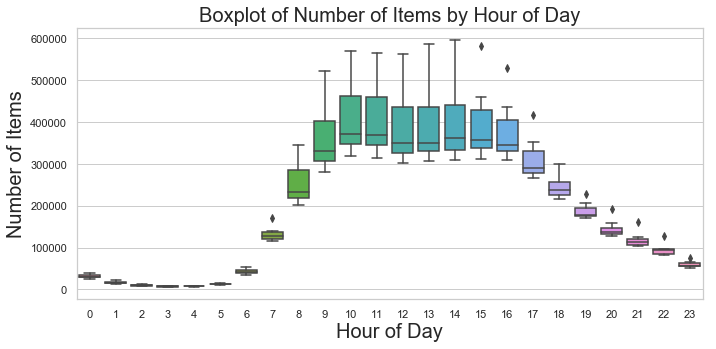

In [41]:
sns.set(style='whitegrid')
plt.subplots(figsize=(10, 5))

sns.boxplot(items_hod['order_hour_of_day'], items_hod['count'])
plt.title('Boxplot of Number of Items by Hour of Day', fontsize=20)
plt.xlabel('Hour of Day', fontsize=20)
plt.ylabel('Number of Items', fontsize=20)

**By no surprise, the overall trend of the number of items purchased by hour of the day resembles that of the number of orders by hour of the day. Likewise, the amount of variation for the hour of the day increases when there are more items purchased.**

### What Aisles are the Most Shopped at by Number of Orders?

In [42]:
aisle_num_ord = mba.groupby('aisle')['order_id'].nunique().reset_index(name='count')
aisle_num_ord['perc'] = aisle_num_ord['count']*100/aisle_num_ord['count'].sum()
aisle_num_ord = aisle_num_ord.sort_values('perc', ascending=False)
aisle_num_ord.head()

,aisle,count,perc
50,fresh fruits,1862949,7.66
53,fresh vegetables,1486803,6.11
98,packaged vegetables fruits,1229500,5.05
133,yogurt,880330,3.62
83,milk,815345,3.35


Text(0,0.5,'Percentage of Orders')

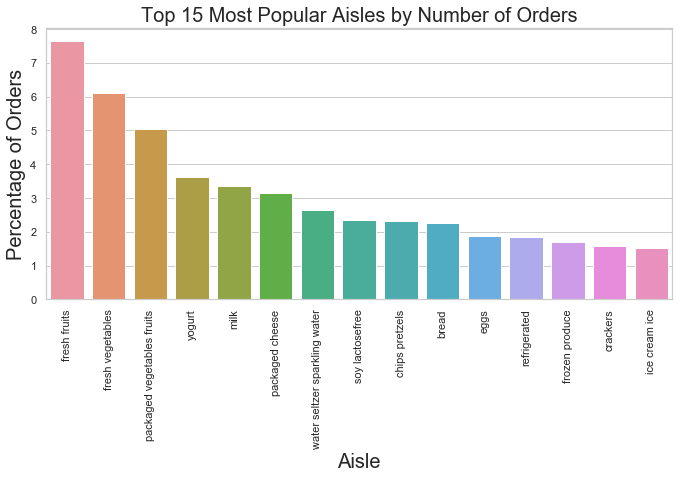

In [43]:
sns.set(style='whitegrid')
plt.subplots(figsize=(10, 5))
plt.xticks(rotation='vertical')

sns.barplot(x=aisle_num_ord['aisle'][:15], y=aisle_num_ord['perc'][:15])
plt.title('Top 15 Most Popular Aisles by Number of Orders', fontsize=20)
plt.xlabel('Aisle', fontsize=20)
plt.ylabel('Percentage of Orders', fontsize=20)

**A significant proportion of orders contain items from the fresh fruits, fresh vegetables, packaged vegetables fruits, yogurt, milk, and cheese aisles.**

### What Aisles are the Most Shopped at by Number of Products?

In [44]:
aisle_num_prod = mba.groupby('aisle')['product_name'].count().reset_index(name='count')
aisle_num_prod['perc'] = aisle_num_prod['count']*100/aisle_num_prod['count'].sum()
aisle_num_prod = aisle_num_prod.sort_values('perc', ascending=False)
aisle_num_prod.head()

,aisle,count,perc
50,fresh fruits,3792661,11.21
53,fresh vegetables,3568630,10.55
98,packaged vegetables fruits,1843806,5.45
133,yogurt,1507583,4.46
93,packaged cheese,1021462,3.02


Text(0,0.5,'Percentage of Items')

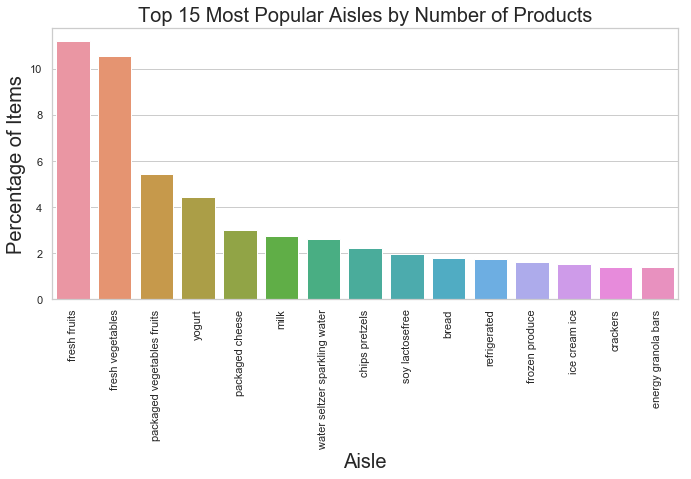

In [45]:
sns.set(style='whitegrid')
plt.subplots(figsize=(10, 5))
plt.xticks(rotation='vertical')

sns.barplot(x=aisle_num_prod['aisle'][:15], y=aisle_num_prod['perc'][:15])
plt.title('Top 15 Most Popular Aisles by Number of Products', fontsize=20)
plt.xlabel('Aisle', fontsize=20)
plt.ylabel('Percentage of Items', fontsize=20)

**Pretty much the same 15 aisles from which the most orders are purchased from is observed for the aisles from which a large proportion of products are purchased, with the exception of the eggs aisles which have been replaced by granola bars. This makes sense because eggs are often bought in packs of half or one dozen whereas singular granola bars can be purchased.**

### What is the Size of the Departments?

Text(0.5,1,'Distribution of Departments')

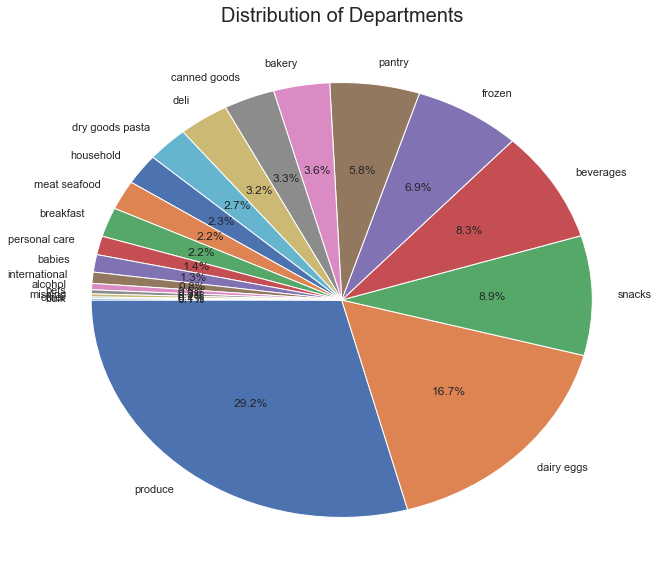

In [46]:
plt.figure(figsize=(10,10))

dept_cts = mba['department'].value_counts()
sizes = dept_cts*100/dept_cts.sum()

plt.pie(sizes, labels=dept_cts.index, autopct='%1.1f%%', startangle=180)
plt.title('Distribution of Departments', fontsize=20)

**The produce (29%), dairy eggs (17%), snacks (9%), beverages (8%), and frozen (7%) departments are the largest. Therefore, it is no surprise that more goods and orders are purchased from these departments' respective aisles.**

### What Departments are the Most Shopped at by Number of Orders?

In [47]:
dept_num_ord = mba.groupby('department')['order_id'].nunique().reset_index(name='count')
dept_num_ord['perc'] = dept_num_ord['count']*100/dept_num_ord['count'].sum()
dept_num_ord = dept_num_ord.sort_values('perc', ascending=False)
dept_num_ord.head()

,department,count,perc
19,produce,2506247,15.80
7,dairy eggs,2264738,14.27
3,beverages,1518833,9.57
20,snacks,1448749,9.13
10,frozen,1232089,7.77


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 <a list of 21 Text xticklabel objects>)

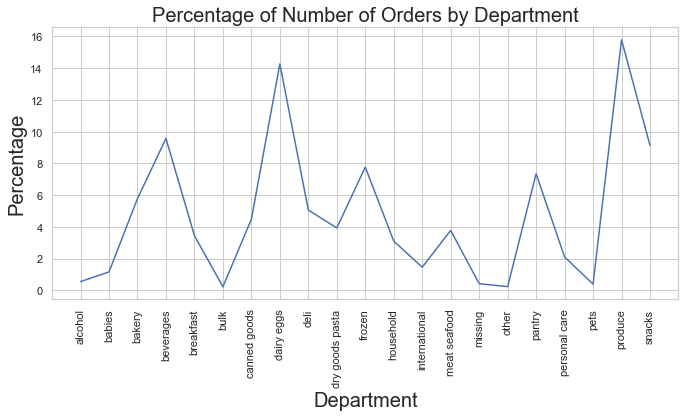

In [48]:
sns.set(style='whitegrid')
plt.subplots(figsize=(10, 5))

sns.lineplot(x=dept_num_ord['department'], y=dept_num_ord['perc'])

plt.title('Percentage of Number of Orders by Department', fontsize=20)
plt.xlabel('Department', fontsize=20)
plt.ylabel('Percentage', fontsize=20)
plt.xticks(rotation='vertical')

**A large percentage of orders are purchased from the produce, dairy eggs, beverages, frozen, and pantry departments. A small percentage of orders are purchased from the alcohol, bulk, missing, other, and pets departments.**

### What Departments are the Most Shopped at by Number of Products?

In [49]:
dept_num_prod = mba.groupby('department')['product_name'].count().reset_index(name='count')
dept_num_prod['perc'] = dept_num_prod['count']*100/dept_num_prod['count'].sum()
dept_num_prod = dept_num_prod.sort_values('perc', ascending=False)
dept_num_prod.head()

,department,count,perc
19,produce,9888378,29.24
7,dairy eggs,5631067,16.65
20,snacks,3006412,8.89
3,beverages,2804175,8.29
10,frozen,2336858,6.91


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 <a list of 21 Text xticklabel objects>)

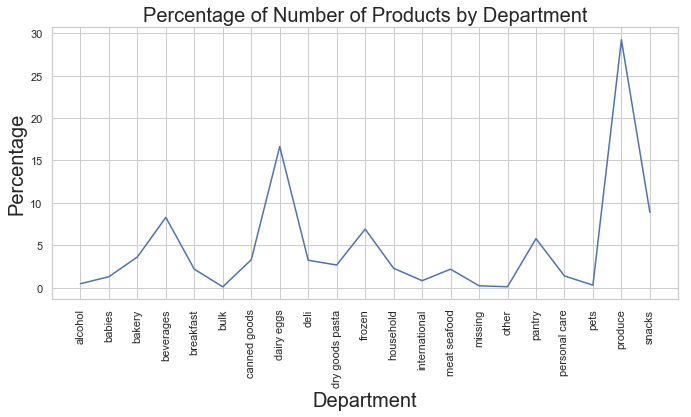

In [50]:
sns.set(style='whitegrid')
plt.subplots(figsize=(10, 5))

sns.lineplot(x=dept_num_prod['department'], y=dept_num_prod['perc'])

plt.title('Percentage of Number of Products by Department', fontsize=20)
plt.xlabel('Department', fontsize=20)
plt.ylabel('Percentage', fontsize=20)
plt.xticks(rotation='vertical')

**Most products are purchased from the produce, dairy eggs, beverages, frozen, and pantry departments. Customers buy products from the alcohol, bulk, missing, other, and pets departments the least. These are the same as the most popular and least popular departments when measuring by the number of orders.**

### What Products Do Customers Order?

In [51]:
pop_prod = mba.groupby('product_name')['product_name'].count().reset_index(name='count')
pop_prod = pop_prod.sort_values('count', ascending=False)
pop_prod['perc'] = pop_prod['count']*100/pop_prod['count'].sum()
pop_prod.head(10)

,product_name,count,perc
3677,Banana,491291,1.45
3472,Bag of Organic Bananas,394930,1.17
31923,Organic Strawberries,275577,0.81
28843,Organic Baby Spinach,251705,0.74
30300,Organic Hass Avocado,220877,0.65
28807,Organic Avocado,184224,0.54
22415,Large Lemon,160792,0.48
42908,Strawberries,149445,0.44
23422,Limes,146660,0.43
32481,Organic Whole Milk,142813,0.42


(0.2, 1.5)

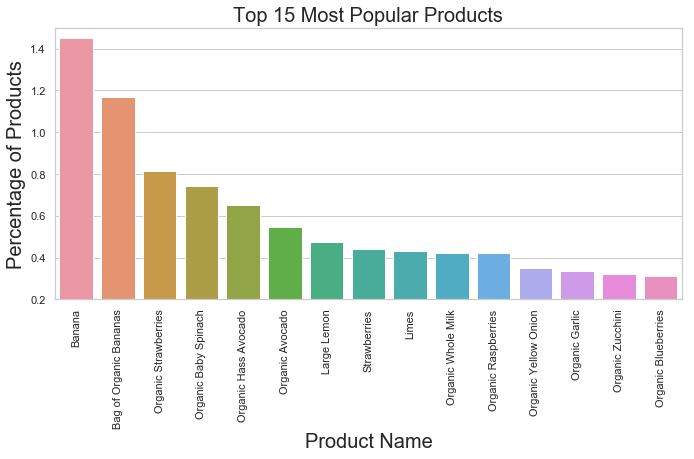

In [52]:
sns.set(style='whitegrid')
plt.subplots(figsize=(10, 5))
plt.xticks(rotation='vertical')

sns.barplot(x=pop_prod['product_name'][:15], y=pop_prod['perc'][:15])
plt.title('Top 15 Most Popular Products', fontsize=20)
plt.xlabel('Product Name', fontsize=20)
plt.ylabel('Percentage of Products', fontsize=20)
plt.ylim(0.2, 1.5)

In [53]:
print('There are {} unique products in the dataset.'.format(len(mba['product_name'].unique())))

There are 49685 unique products in the dataset.


**The majority of the top 15 most sold products are fruits and vegetables, which is verified by the most popular aisles, fresh fruits and fresh vegetables, and the department, produce. Something to note is that of the 15 most frequently bought products, 11 are organic! Let's dive deeper into organic products later.**

### How Often Do Customers Reorder Items?

In [54]:
reord = mba.groupby('reordered')['reordered'].count().reset_index(name='count')
reord['perc'] = reord['count']/reord['count'].sum()
reord

,reordered,count,perc
0,0,13863746,0.41
1,1,19955360,0.59


**59% of the products are reordered, while 41% are not.**

### How Many Days Has It Been Before a Reorder?

In [55]:
days_order = mba.groupby('days_since_prior_order')['order_id'].nunique().reset_index(name='count')
days_order.head()

,days_since_prior_order,count
0,0.00,66562
1,1.00,143727
2,2.00,191219
3,3.00,214681
4,4.00,219094


Text(0,0.5,'Number of Orders')

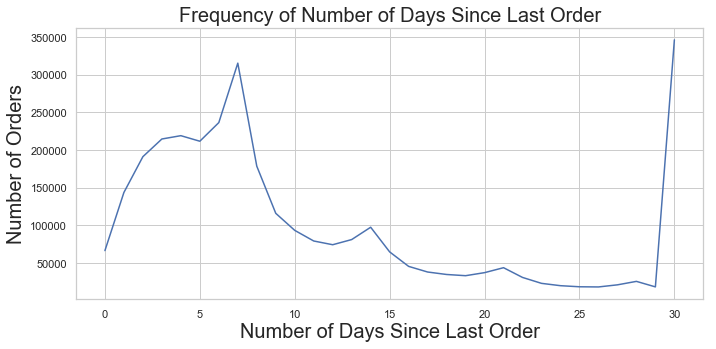

In [56]:
sns.set(style='whitegrid')
plt.subplots(figsize=(10, 5))
sns.lineplot(x=days_order['days_since_prior_order'], y=days_order['count'])

plt.title('Frequency of Number of Days Since Last Order', fontsize=20)
plt.xlabel('Number of Days Since Last Order', fontsize=20)
plt.ylabel('Number of Orders', fontsize=20)

**Users tend to order in intervals of some multiple of 7 (7, 14, 21, or 28 days) or monthly (30 days).**

### What Relationship Does the Number of Days Since the Last Order Have With The Probability of Reordering?

In [57]:
days_reord = mba.groupby('days_since_prior_order')['reordered'].mean().reset_index(name='prob_prior')
days_reord.head()

,days_since_prior_order,prob_prior
0,0.00,0.74
1,1.00,0.62
2,2.00,0.64
3,3.00,0.67
4,4.00,0.68


(0.4, 0.8)

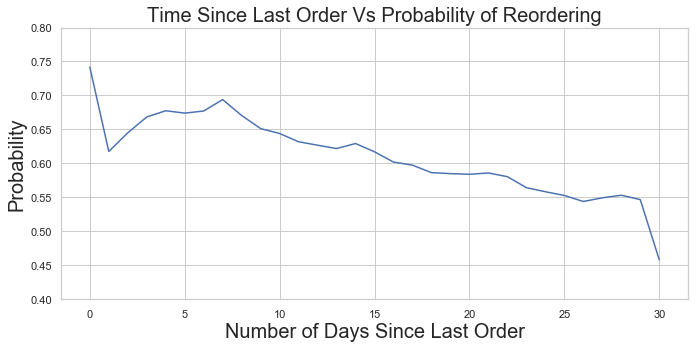

In [58]:
sns.set(style='whitegrid')
plt.subplots(figsize=(10, 5))

sns.lineplot(x=days_reord['days_since_prior_order'], y=days_reord['prob_prior'])

plt.title('Time Since Last Order Vs Probability of Reordering', fontsize=20)
plt.xlabel('Number of Days Since Last Order', fontsize=20)
plt.ylabel('Probability', fontsize=20)
plt.ylim(0.4, 0.8)

**The number of days since the last order is capped from 0-30 days. The overall trend seems to be as more days pass by since the last order, the less likely customers will reorder. This is intuitive because if a customer doesn't like a product, interest for the product and the chances of reordering will fall as time pass. The longer since the last order, the more likely the customer won't reorder.**

### What Relationship Does the Order of Items Placed in Cart Have With The Probability of Reordering?

In [59]:
cart_reord = mba.groupby('add_to_cart_order')['reordered'].mean().reset_index(name='prob_prior')
cart_reord.head()

,add_to_cart_order,prob_prior
0,1,0.68
1,2,0.68
2,3,0.66
3,4,0.64
4,5,0.62


(0, 1)

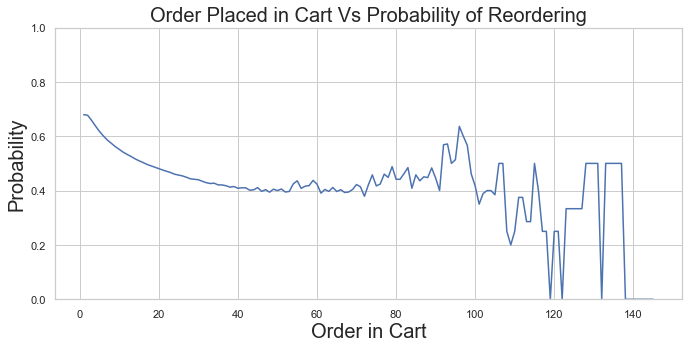

In [60]:
sns.set(style='whitegrid')
plt.subplots(figsize=(10, 5))

sns.lineplot(x=cart_reord['add_to_cart_order'], y=cart_reord['prob_prior'])

plt.title('Order Placed in Cart Vs Probability of Reordering', fontsize=20)
plt.xlabel('Order in Cart', fontsize=20)
plt.ylabel('Probability', fontsize=20)
plt.ylim(0, 1)

**The probability of an item being reordered decreases exponentially as its order added to the cart increases in a cart of size 1 to 50 items. After the 50 item mark, the trend is less coherent with sharp dips and rises. We observe a smoother trend for 1-50 items maybe because most orders don't have more than 50 items. Therefore, the curve of the average probability is smoothed out by the abundant data, whereas there is less data (maybe one or two orders with 9x items) as the order of items placed in cart increases. For example, if a product that was placed 90th in the cart was reordered, this information would greatly affect the average probability of 90th items being reordered.**

### What are Reorder Behaviors by Day of Week?

In [61]:
reord_dow = mba.groupby('order_dow')['reordered'].mean().reset_index(name='prob')
reord_dow

,order_dow,prob
0,Sunday,0.59
1,Monday,0.60
2,Tuesday,0.59
3,Wednesday,0.59
4,Thursday,0.59
5,Friday,0.60
6,Saturday,0.58


(0.55, 0.61)

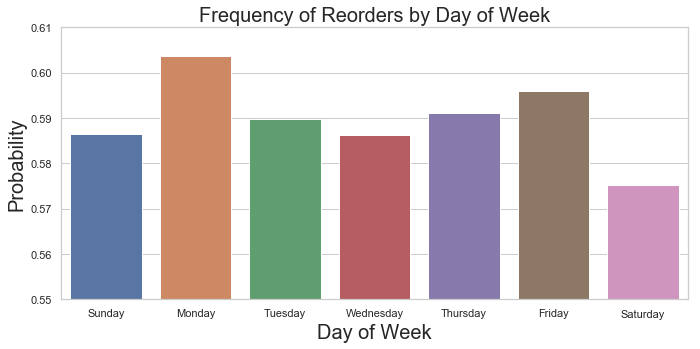

In [62]:
sns.set(style='whitegrid')
f, ax = plt.subplots(figsize=(10, 5))

sns.barplot(reord_dow['order_dow'], y=reord_dow['prob'])
plt.title('Frequency of Reorders by Day of Week', fontsize=20)
plt.xlabel('Day of Week', fontsize=20)
plt.ylabel('Probability', fontsize=20)
plt.ylim(0.55, 0.61)

**Customers on average reorder more on Mondays and Fridays and the least on Saturdays.**

### What are Reorder Behaviors by Hour of Day?

In [63]:
reord_hod = mba.groupby('order_hour_of_day')['reordered'].mean().reset_index(name='prob')
reord_hod

,order_hour_of_day,prob
0,0,0.57
1,1,0.56
2,2,0.56
3,3,0.56
4,4,0.57
5,5,0.61
6,6,0.64
7,7,0.64
8,8,0.63
9,9,0.62


(0.5, 0.65)

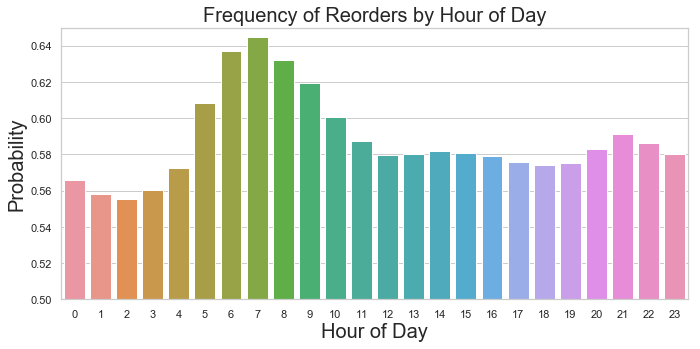

In [64]:
sns.set(style='whitegrid')
plt.subplots(figsize=(10, 5))

sns.barplot(reord_hod['order_hour_of_day'], y=reord_hod['prob'])
plt.title('Frequency of Reorders by Hour of Day', fontsize=20)
plt.xlabel('Hour of Day', fontsize=20)
plt.ylabel('Probability', fontsize=20)
plt.ylim(0.5, 0.65)

**Customers reorder more often during 6-9 AM than the other hours of the day. There is a smaller mode between 8-11 PM, most likely for a regular go-to late night snack or meal.**

### What are Reorder Behaviors by Day of Week Vs Hour of Day?

In [65]:
dow_vs_hod = mba.groupby(['order_dow', 'order_hour_of_day'])['reordered'].mean().reset_index(name='prob')
dow_vs_hod = dow_vs_hod.pivot('order_dow', 'order_hour_of_day', 'prob')
dow_vs_hod.head()

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
order_dow,,,,,,,,,,,,,,,,,,,,,,,,
Sunday,0.58,0.55,0.55,0.57,0.55,0.59,0.62,0.64,0.63,0.61,0.59,0.58,0.58,0.58,0.58,0.58,0.58,0.57,0.57,0.58,0.60,0.61,0.60,0.60
Monday,0.59,0.59,0.56,0.58,0.60,0.63,0.66,0.67,0.66,0.65,0.63,0.61,0.59,0.59,0.59,0.58,0.58,0.58,0.57,0.57,0.58,0.58,0.58,0.58
Tuesday,0.57,0.56,0.57,0.58,0.57,0.61,0.64,0.64,0.63,0.62,0.60,0.59,0.58,0.58,0.58,0.58,0.58,0.57,0.57,0.57,0.57,0.58,0.57,0.57
Wednesday,0.55,0.54,0.54,0.55,0.55,0.61,0.63,0.64,0.62,0.61,0.59,0.58,0.58,0.58,0.57,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.58,0.57
Thursday,0.56,0.54,0.55,0.56,0.58,0.61,0.64,0.64,0.62,0.61,0.59,0.59,0.58,0.58,0.58,0.59,0.58,0.59,0.58,0.58,0.59,0.60,0.58,0.57


Text(34.0531,0.5,'Day of Week')

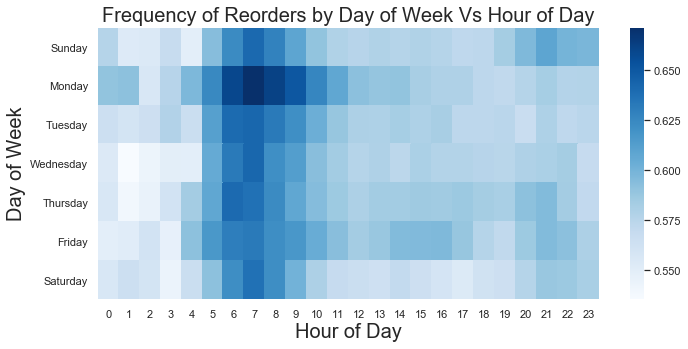

In [66]:
sns.set(style='whitegrid')
plt.subplots(figsize=(10, 5))

sns.heatmap(dow_vs_hod, cmap='Blues')
plt.title('Frequency of Reorders by Day of Week Vs Hour of Day', fontsize=20)
plt.xlabel('Hour of Day', fontsize=20)
plt.ylabel('Day of Week', fontsize=20)

**Overall, customers tend to reorder during the early mornings (5-9 AM) rather than the later half of the day for all days of the week.**

### What Aisles Do Customers Reorder From?

In [67]:
reord_aisle = mba.groupby('aisle')['reordered'].sum().reset_index()
reord_aisle = reord_aisle.merge(aisle_num_prod[['aisle', 'count']], on='aisle')
reord_aisle['prob'] = reord_aisle['reordered']/reord_aisle['count']
reord_aisle = reord_aisle.sort_values('prob', ascending=False)
reord_aisle.head(10)

,aisle,reordered,count,prob
83,milk,722128,923659,0.78
131,water seltzer sparkling water,640988,878150,0.73
50,fresh fruits,2726251,3792661,0.72
41,eggs,333408,472009,0.71
119,soy lactosefree,460069,664493,0.69
96,packaged produce,200319,289488,0.69
133,yogurt,1034957,1507583,0.69
33,cream,226356,330358,0.69
11,bread,408010,608469,0.67
110,refrigerated,397213,599109,0.66


(0.6, 0.8)

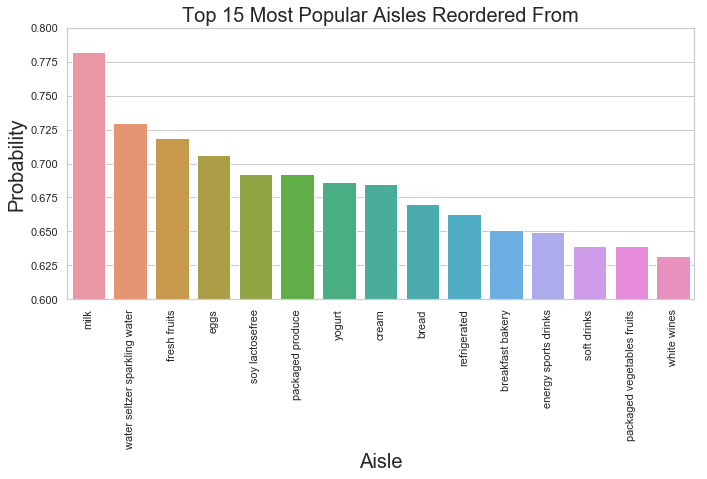

In [68]:
sns.set(style='whitegrid')
plt.subplots(figsize=(10, 5))
plt.xticks(rotation='vertical')

sns.barplot(x=reord_aisle['aisle'][:15], y=reord_aisle['prob'][:15])
plt.title('Top 15 Most Popular Aisles Reordered From', fontsize=20)
plt.xlabel('Aisle', fontsize=20)
plt.ylabel('Probability', fontsize=20)
plt.ylim(0.6, 0.8)

**Customers reorder most from the dairy and eggs, beverages, and produce aisles.**

### What Departments Do Customers Reorder From?

In [69]:
reord_dept = mba.groupby('department')['reordered'].sum().reset_index()
reord_dept = reord_dept.merge(dept_num_prod[['department', 'count']], on='department')
reord_dept['prob'] = reord_dept['reordered']/reord_dept['count']
reord_dept = reord_dept.sort_values('prob', ascending=False)
reord_dept.head(10)

,department,reordered,count,prob
7,dairy eggs,3773723,5631067,0.67
3,beverages,1832952,2804175,0.65
19,produce,6432596,9888378,0.65
2,bakery,769880,1225181,0.63
8,deli,666231,1095540,0.61
18,pets,61594,102221,0.60
1,babies,253453,438743,0.58
5,bulk,20736,35932,0.58
20,snacks,1727075,3006412,0.57
0,alcohol,90992,159294,0.57


(0.3, 0.7)

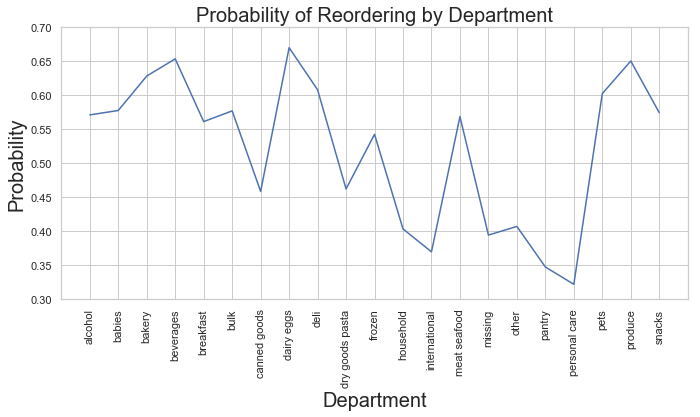

In [70]:
sns.set(style='whitegrid')
plt.subplots(figsize=(10, 5))
plt.xticks(rotation='vertical')

sns.lineplot(x=reord_dept['department'], y=reord_dept['prob'])

plt.title('Probability of Reordering by Department', fontsize=20)
plt.xlabel('Department', fontsize=20)
plt.ylabel('Probability', fontsize=20)
plt.ylim(0.3, 0.7)

**Customers mostly reorder goods from the dairy eggs, beverages, produce, bakery, deli, pets, babies, and snacks departments. Personal care, pantry, and international are some of the least reordered departments.**

### Which Items are Most Frequently Reordered?

In [71]:
prod_reord = mba.groupby(['product_name'])['reordered'].sum().reset_index()
prod_reord = prod_reord.merge(pop_prod[['product_name', 'count']], on='product_name')
prod_reord['prob'] = prod_reord['reordered']/prod_reord['count']
prod_reord = prod_reord.sort_values('prob', ascending=False)
prod_reord.head(10)

,product_name,reordered,count,prob
37379,Raw Veggie Wrappers,65,69,0.94
39870,Serenity Ultimate Extrema Overnight Pads,84,90,0.93
28415,Orange Energy Shots,12,13,0.92
8537,Chocolate Love Bar,94,102,0.92
41723,Soy Powder Infant Formula,32,35,0.91
40458,Simply Sleep Nighttime Sleep Aid,41,45,0.91
13844,"Energy Shot, Grape Flavor",20,22,0.91
38793,Russian River Valley Reserve Pinot Noir,27,30,0.90
3832,Bars Peanut Butter,62,69,0.90
41712,Soy Crisps Lightly Salted,60,67,0.90


(0.85, 0.95)

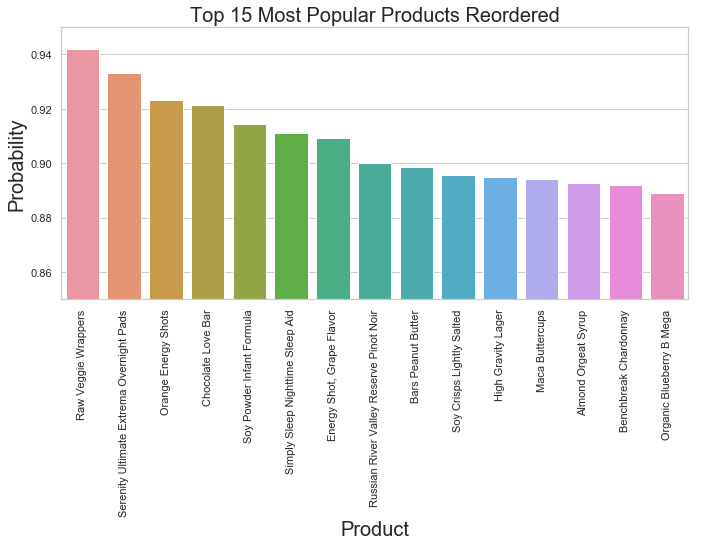

In [72]:
sns.set(style='whitegrid')
plt.subplots(figsize=(10, 5))
plt.xticks(rotation='vertical')

sns.barplot(x=prod_reord['product_name'][:15], y=prod_reord['prob'][:15])
plt.title('Top 15 Most Popular Products Reordered', fontsize=20)
plt.xlabel('Product', fontsize=20)
plt.ylabel('Probability', fontsize=20)
plt.ylim(0.85, 0.95)

**The top 15 most reordered items are entirely different from the 15 most popular items. By just looking at the names, the above products are more specific, whereas the most frequently bought items are very generic such as "bananas" or "key limes". This might be because the 15 most bought items are mostly fruits and vegetables that are only available during specific seasons and can be substituted by other produce in the meantime. On the other hand, the 15 most reordered items might not have close substitutes or have strong brand loyalty; hence, the higher inclination for customers to repurchase those items.**

### How Often Do Customers Order Organic Items?

In [73]:
mba['organic'] = np.where(mba['product_name'].str.contains('Organic'), 1, 0)

In [74]:
organic_cts = mba.groupby('organic')['organic'].count().reset_index(name='count')
organic_cts['perc'] = organic_cts['count']/organic_cts['count'].sum()
organic_cts

,organic,count,perc
0,0,23163118,0.68
1,1,10655988,0.32


**32% of the products are organic while 68% are not. This is reasonable because besides departments like produce and dairy and eggs, most departments like deli, bulk, and frozen don't provide organic options.**

### How Often Do Customers Reorder Organic Items?

In [75]:
organic_reord = mba.groupby('organic')['reordered'].mean().reset_index(name='prob')
organic_reord

,organic,prob
0,0,0.57
1,1,0.64


**Although only a third of the products are organic, there is almost a 2/3 chance that an organic product will be reordered.**

## Most important Aisles in each Department (by number of Products)

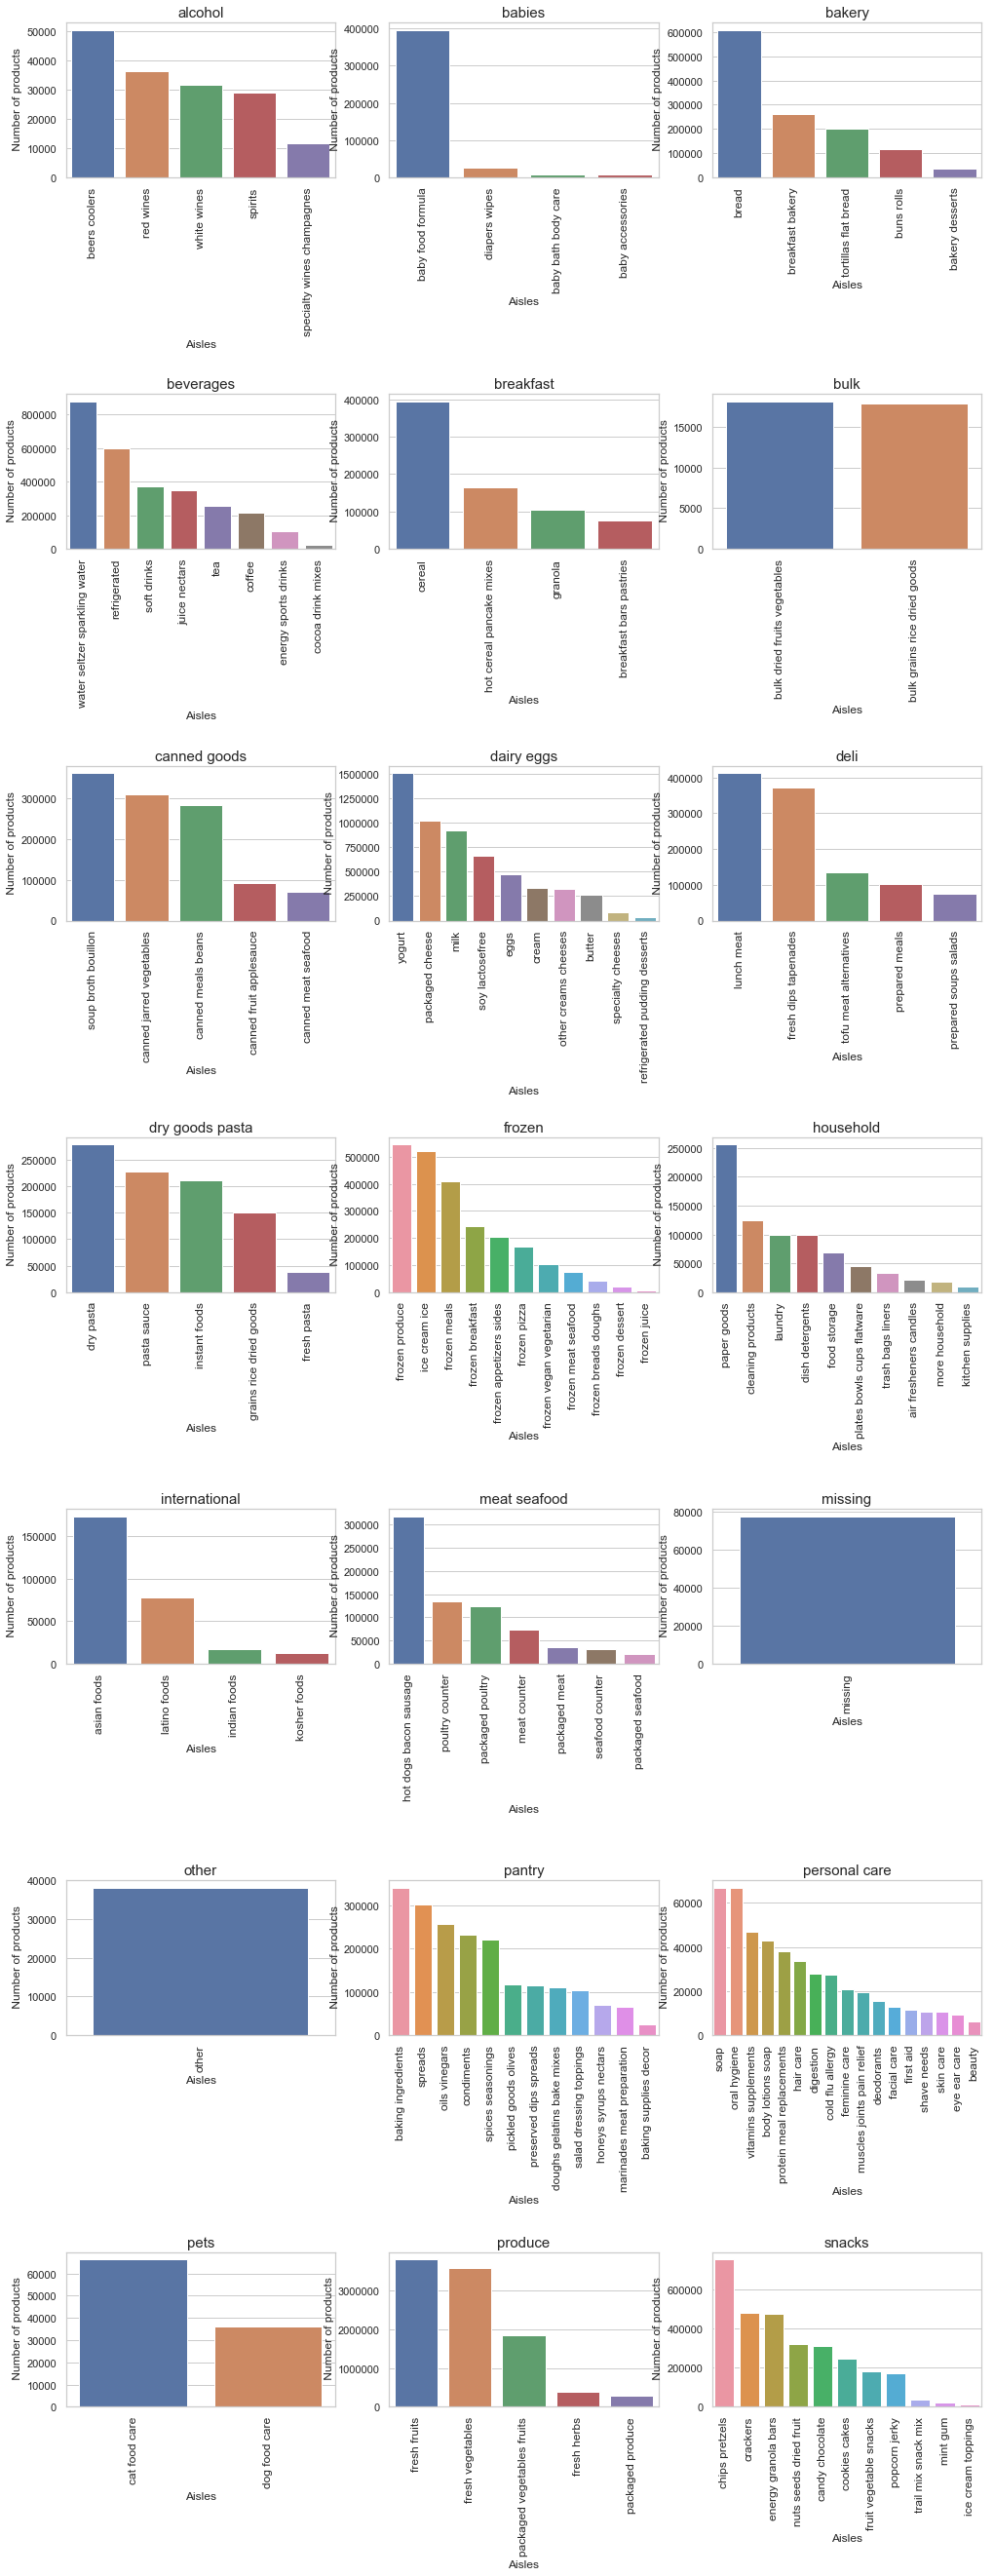

In [76]:
grouped = mba.groupby(["department", "aisle"])["product_name"].aggregate({'Total_products': 'count'}).reset_index()
grouped.sort_values(by='Total_products', ascending=False, inplace=True)
fig, axes = plt.subplots(7, 3, figsize=(15,45), gridspec_kw =  dict(hspace=1.4))
for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(group.aisle, group.Total_products , ax=ax)
    ax.set(xlabel = "Aisles", ylabel=" Number of products")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)

## Best Selling Aisles in each Department (number of Orders)

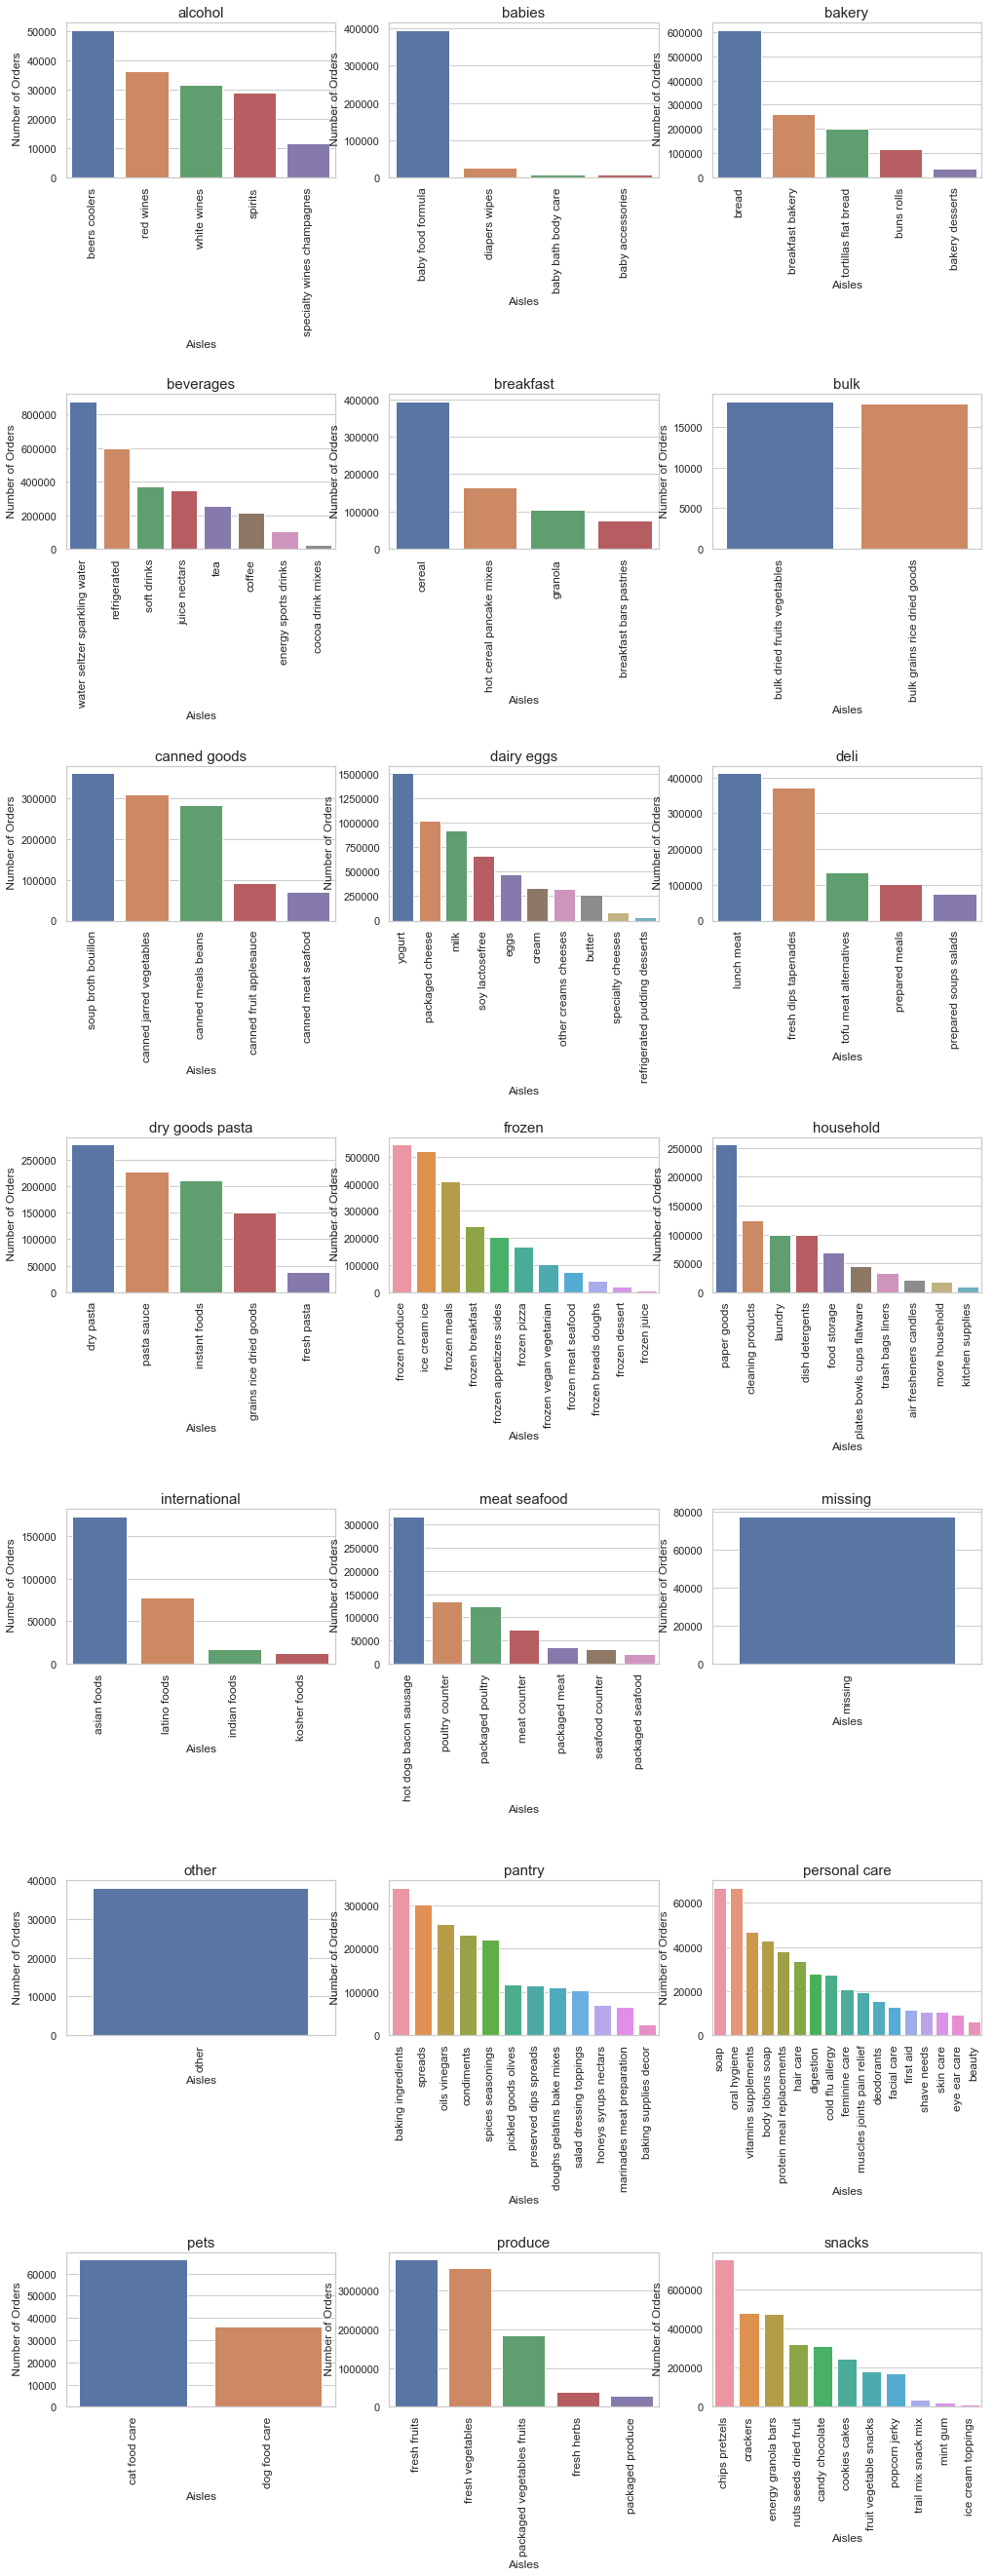

In [77]:
grouped = mba.groupby(["department", "aisle"])["order_id"].aggregate({'Total_orders': 'count'}).reset_index()
grouped.sort_values(by='Total_orders', ascending=False, inplace=True)
fig, axes = plt.subplots(7,3, figsize=(15,45), gridspec_kw =  dict(hspace=1.4))
for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(group.aisle, group.Total_orders , ax=ax)
    ax.set(xlabel = "Aisles", ylabel=" Number of Orders")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)

## Exploratory Data Analysis Findings Summary

**`order_number`:**
- **The least number of orders a customer placed is 1**
- **The average customer placed 17 orders**
- **Half the customers placed less than 11 orders or less while the other half placed 11 orders or more**
- **the most number of orders placed by a customer is 100**
- **The distribution is slightly right skewed (mean > median)**

**`order_hour_of_day`:**
- **On average, orders were placed between 1-2 PM (13.43)**
- **Half the orders were placed on or before 1 PM, while the other half on or after 1 PM**

**`days_since_prior_order`**:
- **Because this feature is capped at 30 days, the maximum is 30**
- **Because customers can place more than one order a day, the minimum is 0**
- **On average, the previous order was placed roughly 11 days ago**
- **Half the orders were placed 8 or less days ago, while the other half were placed 8 or more days ago**

**`add_to_cart_order`**:
- **The average number of items in a cart is about 8**
- **The minimum cart size is 1**
- **The maximum cart size is 145**
- **The median cart size is 6, which means that the data for this column is right skewed because the median is less than the mean**

**`reordered`:**
- **59% of the time products were reordered**

#### How Many Orders Do Customers Place?
- **Most customers placed around 4-7 Instacart orders. There seems to be a bump at 100 orders because the dataset is capped at 4-100 orders; hence, 100+ orders are lumped into the 100 orders category. The orginal orders dataset contains users with 4-100 orders. However, there are some users with 3 orders because one of their orders were in the test set that was omitted when combining the datasets to create the MBA dataset.**
- **A majority of the customers had approximately 3 to 40 orders. The median seems to be located at 10 orders, and the spread (Q3 - Q1 = ~15) of the middle 50% of the data is fairly small.**

#### How Many Orders Do Customers Place by Day of Week?
- **There are more orders placed early on in the week (Sunday, and Monday). This may be because users shop for groceries for the rest of the week. The number of orders decreases into the middle of the week and increases again as the weekend approaches, which may be because working families have more time to cook on the weekends.**
- **There is more spread for Sunday and Monday, and the median number of orders fluctuates between 1500000 to 200000 across the different days of the week.**


#### How Many Orders Do Customers Place by Hour of Day?
- **The number of orders are the highest at 10 AM and 3 PM. Users tend to order around noon as indicated by the rounded top of the peak. This might be because users are purchasing already made salads for lunchtime and groceries before dinner time. Hence, we observe that users don't usually order during or after dinner hours. The number of orders start plummeting after 4 PM. We observe few orders before midnight and between midnight and 6AM because not a lot of stores open until midnight and most stores don't open until 6 AM.**
- **The median number of orders increases throughout the day until 4 PM, peaking around the late morning (10 AM - 11 PM) to early afternoon hours (12 PM - 3 PM). The spread also increases with the median because there are more orders rolling in and therefore more variability in the data than late in the evening or during the wee hours.**

#### How Many Orders Do Customers Place by Day of Week vs. Hour of Day?
- **Most orders are placed between 10 AM - 4 PM on Sundays and 9 AM - 3 PM on Mondays. Customers also tend to place orders between 11 AM - 3 PM on Saturdays but at a lower frequency.**


#### How Many Items are in the Orders?
- **Most people, on average, have around 3-8 items in each order.**
- **The spread (Q3 - Q1) of the middle 50% of the data is roughly 10. The data is right skewed with a maximum of 145 items in a single order. Most of the orders contain 1-30 products although there are quite a number of orders with more than 30 items displayed as outliers (individual points plotted beyond the upper whisker of the boxplot).**

#### How Many Items Do Customers Order by Day of Week?
- **This is consistent with what we have been seeing: there are more orders placed during Monday and the weekends. Hence, there should be more items purchased on these days of the week.**
- **Again, there's more spread for Sunday and Monday and the trend for the median numbers of items purchased across the days of the week mirror the heights of the above barplots.**

#### How Many Items Do Customers Order by Hour of Day?
- **The trend of the number of items purchased by hour of day is similar to that of the number of orders placed by hour of day. This is consistent with our intuition that the number of items purchased is directly proportional to the number of orders placed: the more orders placed, the more items purchased.**
- **By no surprise, the overall trend of the number of items purchased by hour of the day resembles that of the number of orders by hour of the day. Likewise, the amount of variation for the hour of the day increases when there are more items purchased.**

#### What Aisles are the Most Shopped at by Number of Orders?
- **A significant proportion of orders contain items from the fresh fruits, fresh vegetables, packaged vegetables fruits, yogurt, milk, and cheese aisles.**

#### What Aisles are the Most Shopped at by Number of Products?
- **Pretty much the same 15 aisles from which the most orders are purchased from is observed for the aisles from which a large proportion of products are purchased, with the exception of the eggs aisles which have been replaced by granola bars. This makes sense because eggs are often bought in packs of half or one dozen whereas singular granola bars can be purchased.**

#### What is the Size of the Departments?
- **The produce (29%), dairy eggs (17%), snacks (9%), beverages (8%), and frozen (7%) departments are the largest. Therefore, it is no surprise that more goods and orders are purchased from these departments' respective aisles.**

#### What Departments are the Most Shopped at by Number of Orders?
- **A large percentage of orders are purchased from the produce, dairy eggs, beverages, frozen, and pantry departments. A small percentage of orders are purchased from the alcohol, bulk, missing, other, and pets departments.**

#### What Departments are the Most Shopped at by Number of Products?
- **Most products are purchased from the produce, dairy eggs, beverages, frozen, and pantry departments. Customers buy products from the alcohol, bulk, missing, other, and pets departments the least. These are the same as the most popular and least popular departments when measuring by the number of orders.**

#### What Products Do Customers Order?
- **The majority of the top 15 most sold products are fruits and vegetables, which is verified by the most popular aisles, fresh fruits and fresh vegetables, and the department, produce. Something to note is that of the 15 most frequently bought products, 11 are organic! Let's dive deeper into organic products later.**

#### How Often Do Customers Reorder Items?
- **59% of the products are reordered, while 41% are not.**

#### How Many Days Has It Been Before a Reorder?
- **Users tend to order in intervals of some multiple of 7 (7, 14, 21, or 28 days) or monthly (30 days).**

#### What Relationship Does the Number of Days Since the Last Order Have With The Probability of Reordering?
- **The number of days since the last order is capped from 0-30 days. The overall trend seems to be as more days pass by since the last order, the less likely customers will reorder. This is intuitive because if a customer doesn't like a product, interest for the product and the chances of reordering will fall as time pass. The longer since the last order, the more likely the customer won't reorder.**

#### What Relationship Does the Order of Items Placed in Cart Have With The Probability of Reordering?
- **The probability of an item being reordered decreases exponentially as its order added to the cart increases in a cart of size 1 to 50 items. After the 50 item mark, the trend is less coherent with sharp dips and rises. We observe a smoother trend for 1-50 items maybe because most orders don't have more than 50 items. Therefore, the curve of the average probability is smoothed out by the abundant data, whereas there is less data (maybe one or two orders with 9x items) as the order of items placed in cart increases. For example, if a product that was placed 90th in the cart was reordered, this information would greatly affect the average probability of 90th items being reordered.**

#### What are Reorder Behaviors by Day of Week?
- **Customers on average reorder more on Mondays and Fridays and the least on Saturdays.**

#### What are Reorder Behaviors by Hour of Day?
- **Customers reorder more often during 6-9 AM than the other hours of the day. There is a smaller mode between 8-11 PM, most likely for a regular go-to late night snack or meal.**

#### What are Reorder Behaviors by Day of Week Vs Hour of Day?
- **Overall, customers tend to reorder during the early mornings (5-9 AM) rather than the later half of the day for all days of the week.**

#### What Aisles Do Customers Reorder From?
- **Customers reorder most from the dairy and eggs, beverages, and produce aisles.**

#### What Departments Do Customers Reorder From?
- **Customers mostly reorder goods from the dairy eggs, beverages, produce, bakery, deli, pets, babies, and snacks departments. Personal care, pantry, and international are some of the least reordered departments.**

#### Which Items are Most Frequently Reordered?
- **The top 15 most reordered items are entirely different from the 15 most popular items. By just looking at the names, the above products are more specific, whereas the most frequently bought items are very generic such as "bananas" or "key limes". This might be because the 15 most bought items are mostly fruits and vegetables that are only available during specific seasons and can be substituted by other produce in the meantime. On the other hand, the 15 most reordered items might not have close substitutes or have strong brand loyalty; hence, the higher inclination for customers to repurchase those items.**

#### How Often Do Customers Order Organic Items?
- **32% of the products are organic while 68% are not. This is reasonable because besides departments like produce and dairy and eggs, most departments like deli, bulk, and frozen don't provide organic options.**

#### How Often Do Customers Reorder Organic Items?
- **Although only a third of the products are organic, there is almost a 2/3 chance that an organic product will be reordered.**

## Share Data with the Market Basket Analysis and Customer Segmentation Notebooks

In [82]:
import pickle

In [84]:
mba.to_pickle('mba.pickle')
num_items_order.to_pickle('num_items_order.pickle')